# Exploration.11 - ARIMA 모델을 활용하여 주식 가격 예측

## 기본 개념

- 미래 예측의 두가지 전제  
    - 과거의 데이터에 일정한 패턴이 발견된다.
    - 과거의 패턴은 미래에도 동일하게 반복될 것이다.  
(안정적(Stationary) 데이터에 대해서만 미래 예측이 가능하다)
<br><br>
- 안정적(Stationary): 시계열 데이터의 통계적 특성이 변하지 않음을 말함

## import Package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

## Data 불러오기 - 삼성전자

In [2]:
def load_data(file_name):
    dataset_filepath = '../Data/Exploration.11/'+file_name
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
    return df

In [3]:
df = load_data('005930.KS.csv') # 삼성전자
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


- 종가를 나타내는 Close 변수만 활용할 예정

In [4]:
ts = df['Close']

ts.head(15)

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
2020-05-25    48850.0
2020-05-26    49250.0
2020-05-27    49900.0
2020-05-28    50400.0
2020-05-29    50700.0
2020-06-01    51200.0
2020-06-02    51400.0
2020-06-03    54500.0
2020-06-04    54600.0
2020-06-05    55500.0
Name: Close, dtype: float64

In [5]:
len(ts)

250

- 주식 정보는 총 250일 동안에 해당하는 데이터만 있음

## Preprocessing

### 1. 결측치 확인

In [6]:
ts.isnull().sum()

0

- 결측치는 존재하지 않음

### 2. 인덱스(날짜) 중복 여부 판단

In [7]:
len(ts.index.unique())

250

- unique()를 통해 고유한 index를 나타냄
- len()을 통해 고유한 index의 갯수를 파악
- data 갯수와 고유한 index의 갯수가 일치함
- index의 중복을 없을 것으로 판단됨

## 3. log 변환

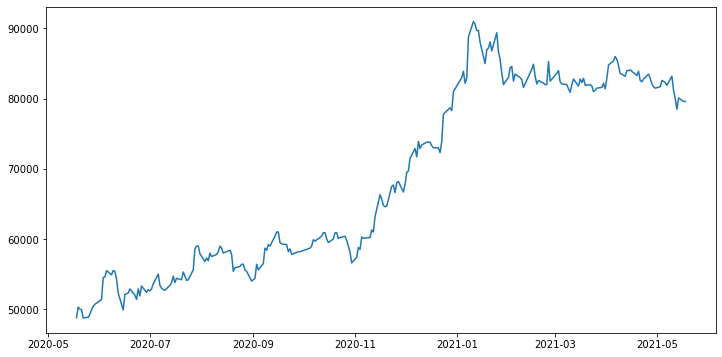

In [8]:
rcParams['figure.figsize'] = 12, 6
plt.plot(ts)

- 시간 추이에 따라 분산이 점점 커짐
- log변환이 필요함

In [9]:
ts_log = np.log(ts)

- ts를 log 변환시킴

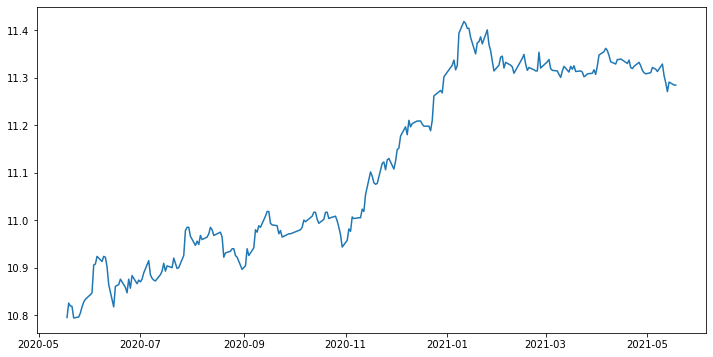

In [10]:
rcParams['figure.figsize'] = 12, 6
plt.plot(ts_log)

- log 변환을 통해 작은 값은 비교적 커지고 큰 값은 비교적 작아짐

## 시계열 안정성 분석

- 시계열적으로 안정적이지 않은 주식 그래프를 분석하고 안정적인 형태로 변환하는 과정이 필요함

### 1. Augmented Dickey-Fuller 검정

#### 1-1. Dickey-Fuller 단위근 검정
- 단위근이 존재한다는 귀무가설을 통계적으로 검정하는 방법
- 단위근 : 단위가 1인 근
- **이해가 안가는 점 발생 : 단위근이 존재하면 왜 시계열 데이터가 안정적이지 않은지 여러 자료를 찾아봐도 이해가 안감**  
(확률보행(임의보행)과정에 대한 추가적인 조사 필요)
- 모형이 안정적이면 α < 1
- p-value를 통해 귀무가설을 기각해야하는지 채택해야하는지를 결정해야함

#### 1-2. ADF 검정
- DF 검정의 식에서 p lag의 차분만큼 항이 추가
- t−p 시점까지의 차분 경향성을 파악할 수 있어서 주기를 가진 데이터의 정상성 여부를 판단할 수 있음
- ADF 검정의 귀무가설은 DF 검정과 귀무가설과 같음

#### 1-3. ADF 검정을 위한 함수 만들기

In [11]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [12]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- ts_log의 p-value는 약 0.59로 매우 높음
- 귀무가설을 기각할 수 없음
- 현재까지의 데이터는 안정적이지 않음

### 2. 이동평균
- 수의 집합에서 특정 크기의 부분 집합을 연속적으로 이동하며 산출한 평균
- 일반 평균 : 한정되어 있는 수 집합의 모든 값을 대상으로 한 평균
- 이동평균 : 일정한 크기의 부분집합을 평균 계산에 활용
- 부분집합을 이동시키며 연속적인 평균을 산출
- 평균값의 흐름을 알 수 있게 함 (일정기간 혹은 데이터 구간의 평균 흐름 파악 가능)

In [13]:
def plot_rolling_statistics(timeseries, window=5):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

- window : 이동평균을 구할 부분집합의 크기
- 일주일에 따른 이동평균을 보기 위해 window=5로 지정함  
(토요일과 일요일에는 장이 안열리므로 window=5로 지정함)

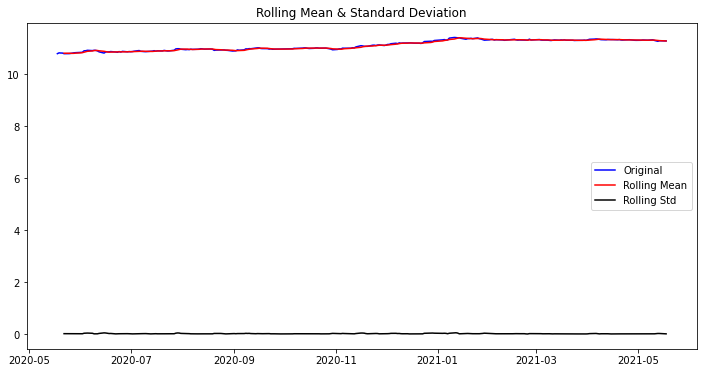

In [14]:
plot_rolling_statistics(ts_log, window=5)

- 기존 함수를 이용하면 표준편차와 평균값의 scale의 격차가 크기 때문에 유의미한 시간적 분석이 불가능함

In [15]:
def plot_rolling_only_mean(timeseries, window=5):
    
    rolmean = timeseries.rolling(window=window).mean()

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')

    plt.legend(loc='best')
    plt.show(block=False)

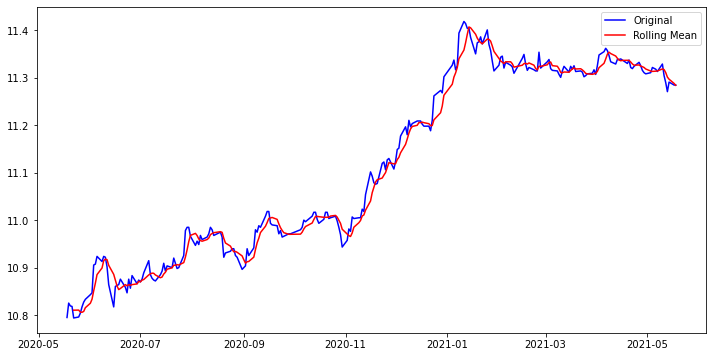

In [16]:
plot_rolling_only_mean(ts_log, window=5)

### 3. Moving average 제거 - 추세(Trend) 상쇄하기
- 추세(trend)
    - 시계열 분석에서 시간 추이에 따라 나타나는 평균값 변화
    - 데이터가 장기적으로 증가하거나 감소할 때, 추세(trend)가 존재함
    - 추세가 선형적일 필요는 없음
    - 때때로 어떤 추세가 증가에서 감소로 변화하는 경우에, 그것을 추세의 “방향이 변화했다”라고 언급함
- 이 변화량을 제거해 주려면 거꾸로 Moving Average, 즉 rolling mean을 구해서 ts_log에서 빼줌

In [17]:
moving_avg = ts_log.rolling(window=5).mean() 
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head()

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22   -0.016392
Name: Close, dtype: float64

- ts_log_moving_avg : ts_log와 이동평균의 차이값
<br><br>
- 문제점
    - Moving Average 계산 시 (windows size=5인 경우) 앞의 4개의 데이터는 Moving Average가 계산되지 않음
    - ts_log_moving_avg에 결측치(NaN)가 발생한다는 점입니다.
    - 이 결측치들은 향후 Dicky-Fuller Test 시에 에러를 발생시킬 것이므로 이를 데이터셋에서 제거

In [18]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head()

Date
2020-05-22   -0.016392
2020-05-25   -0.014548
2020-05-26   -0.002174
2020-05-27    0.011339
2020-05-28    0.019515
Name: Close, dtype: float64

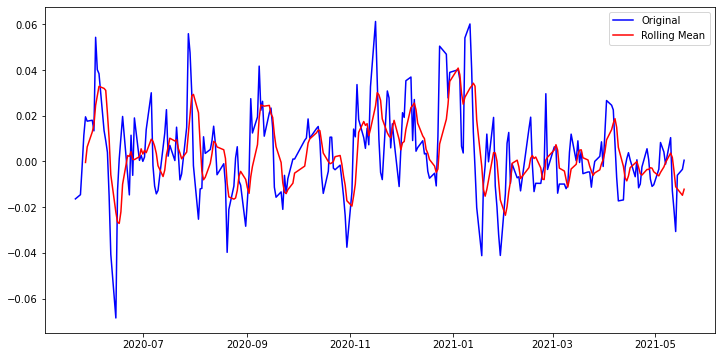

In [19]:
plot_rolling_only_mean(ts_log_moving_avg)

- 위의 그래프는 실제값과 이동평균의 차이에 대한 그래프
- trend를 제거하고 이동평균에 따른 분포(실제값-이동평균)를 볼 수 있음
- trend를 제거하기 전보다 데이터 간의 분산이 줄어든 것을 볼 수 있음

In [20]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                -7.801633e+00
p-value                        7.466367e-12
#Lags Used                     1.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


### 3. 차분(Differencing) - 계절성(Seasonality) 상쇄하기
- 계절성(Seasonality)
    - 패턴이 파악되지 않은 주기적 변화(계절적, 주기적 패턴)
- 해마다 어떤 특정한 때나 1주일마다 특정 요일에 나타나는 것 같은 계절성 요인이 시계열에 영향을 줄 때 나타나는 패턴
- 계절성은 빈도의 형태로 나타남 (빈도는 항상 일정함)

- 차분
    - 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법
    - 현재 스텝 값 - 직전 스텝 값
    - 이번 스텝에서 발생한 변화량을 의미

In [21]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift

ts_log_moving_avg_diff.dropna(inplace=True)

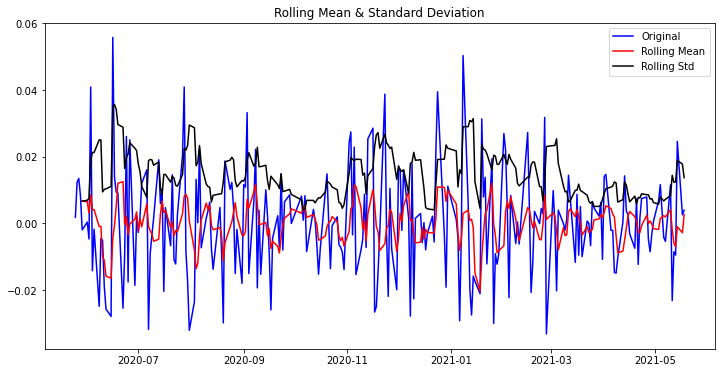

In [22]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [23]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -9.922422e+00
p-value                        2.966712e-17
#Lags Used                     5.000000e+00
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


- 계절성을 제거하고 p-value가 더 떨어진 것을 볼 수 있음
- 시계열 데이터가 안정적이게 됨

### 4. 시계열 분해

- statsmodels 라이브러리 안에는 seasonal_decompose 메서드를 통해 위에서 했던 작업을 건너뛰고 trend, seasonality를 직접 분리 가능

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

def seperater_pattern_detail(data):
    decomposition = seasonal_decompose(data, model='multiplicative', period = 30)

    trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
    seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
    residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

    plt.rcParams["figure.figsize"] = (11,6)
    plt.subplot(411)
    plt.plot(data, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()

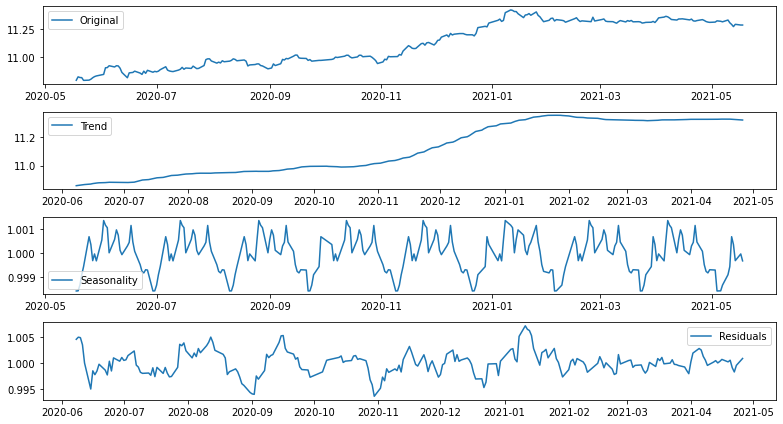

In [25]:
seperater_pattern_detail(ts_log)

- Original = Trend + Seasonality + Residual
- Residual = Original - Trend - Seasonality

In [26]:
def residual_detail(data):
    decomposition = seasonal_decompose(data, model='multiplicative', period = 30)
    residual = decomposition.resid
    
    plt.rcParams["figure.figsize"] = (13,6)
    plot_rolling_only_mean(residual)
    
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)

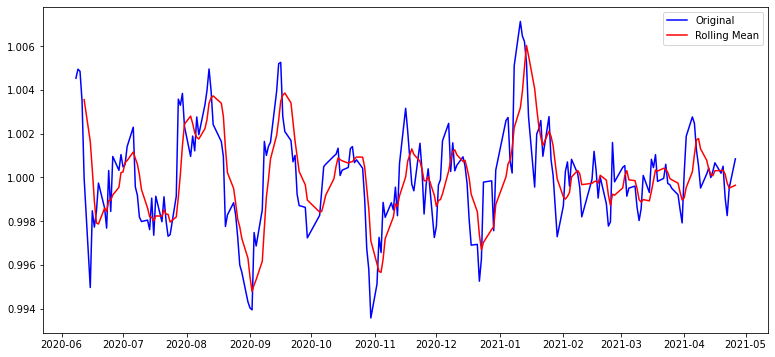

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


In [27]:
residual_detail(ts_log)

- p-value가 0에 가까워 시계열 데이터가 안정적이라고 할 수 있음
- 이번 데이터를 ARIMA 모델로 학습 가능

## Train, Test셋 분리

In [28]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

In [29]:
def plot_train_test(data, test_data):
    
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(data, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()

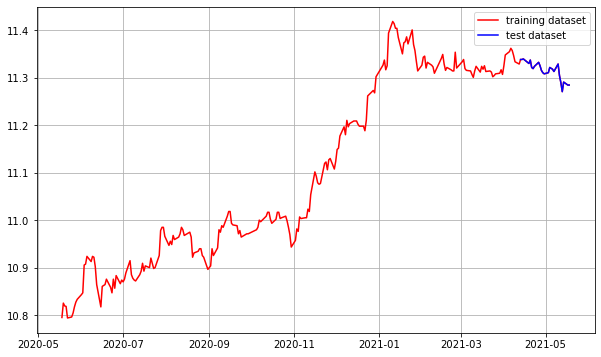

In [30]:
plot_train_test(ts_log, test_data)

- ts_log의 0번부터 90퍼센트 전까지는 train_data로 지정
- ts_log의 90퍼센트 지점부터 마지막 데이터까지는 test_data로 지정

In [31]:
print(train_data.shape)
print(test_data.shape)

(225,)
(25,)


- train data는 225일 동안의 주식 가격, test data는 25일 동안의 주식 가격

## ARIMA(Autoregressive Integrated Moving Average)
- ARIMA : AR(Autoregressive) + I(Integrated) + MA(Moving Average)

### 1-1. AR(자기회귀, Autoregressive)

- 과거 값들에 대한 회귀로 미래 값을 예측하는 방법
- AR은 시계열의 Residual에 해당하는 부분을 모델링
- 주식값이 항상 일정한 균형 수준을 유지할 것이라고 예측하는 관점  
(주식값이 떨어졌을 때, 주식이 올라서 균형을 맞추겠지?라는 관점)

### 1-2. MA(이동평균, Moving Average)

- MA는 시계열의 Trend에 해당하는 부분을 모델링
- 예측오차값이 0보다 크면 모델 예측보다 관측값이 더 높다는 뜻 (다음 예측 시에는 예측치를 올려잡음)
- 주식값이 최근 증감 패턴을 지속할 것이라고 보는 관점  
(주식값이 떨어졌을 때, 떨어졌으니 추세적으로 계속 떨어지지 않을까?라는 관점)

### 1-3. I(차분 누적, Integration)

- I는 시계열의 Seasonality에 해당하는 부분을 모델링
- I는 Y(t)이 이전 데이터와 d차 차분의 누적(integration) 합  
(예를 들어 d=1이라면 Y(t)는 Y(t-1)과 ΔY(t−1)의 합)

## ARIMA 모델의 모수 찾기 (p, d, q)

- p : 자기회귀 모형(AR)의 시차
- d : 차분 누적(I) 횟수
- q : 이동평균 모형(MA)의 시차

### 1. ACF(Autocorrelation Function)

- 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
- y(t)와 y(t+k) 사이에 correlation을 측정
<br><br>
- MA(q)를 찾는데 활용

### 2. PACF(Partial Autocorrelation Function

- 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수
- t와 t+k 사이에 다른 y값들의 영향력을 배제하고 y(t)와 y(t+k)의 correlation을 측정
<br><br>
- AR(p)를 찾는데 활용
- https://direction-f.tistory.com/65

### 3. p, q 구하기

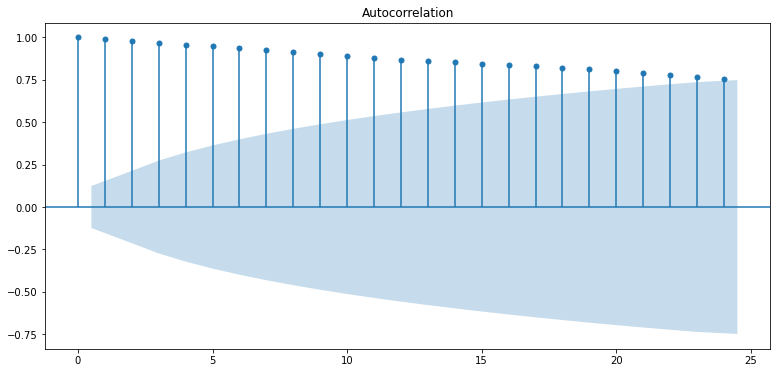

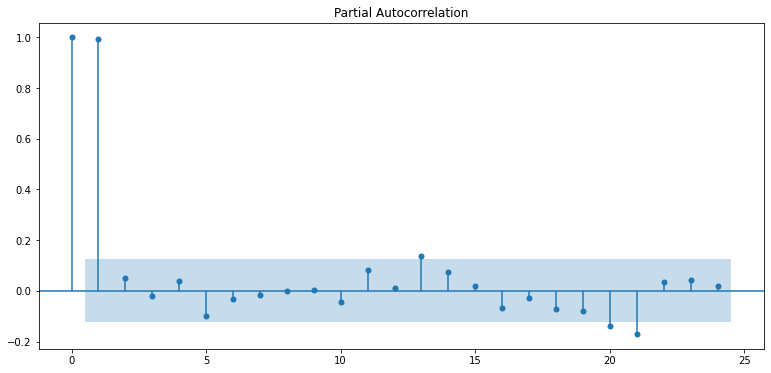

In [32]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

![acf_pacf](https://d3s0tskafalll9.cloudfront.net/media/images/E-16-4.max-800x600.png)

- Lag 0은 자기자신과의 관련성이므로 ACF와 PACF 모두 1임
- ACF는 시차 간격이 벌어지면서 관련성이 점차 떨어질 수 있으므로 점차적으로 감소함
- PACF가 1번 이후에 0에 가까워짐
- AR(1)에 적합함
- AR(13), AR(21) 부근도 고려해보려고 함

### 4. d를 구하기
- d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 보아야 함

#### 4-1. 1차 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


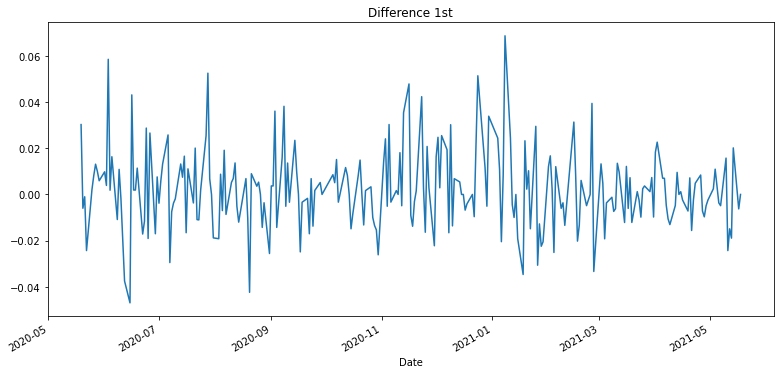

In [33]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#### 4-2. 2차 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


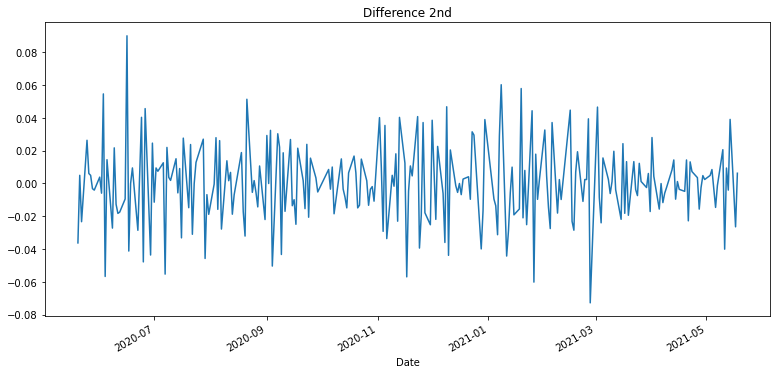

In [34]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 1차 차분의 p-value값이 2차 차분의 p-value값보다 낮아 1차 차분을 활용
- d = 1로 지정

### 모수 p, d, q는 (1, 1, 0)으로 지정함

## ARIMA 모델 훈련

In [35]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  # (p, d, q)
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Fri, 11 Feb 2022   AIC                          -1162.976
Time:                        15:34:01   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

## 훈련 결과

In [36]:
def result_pred(fitted_m, train_data):
    pred = fitted_m.predict()
    pred = pred.drop(pred.index[0])
    plt.plot(pred, label='predict')
    plt.plot(train_data, label='train_data')
    plt.legend()

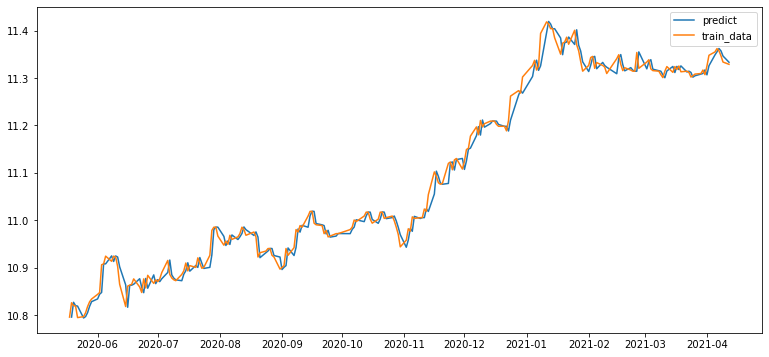

In [37]:
result_pred(fitted_m, train_data)

- 학습을 통해 얻은 예측값(Pred)과 실제 train_data의 주식 가격 변동 흐름은 비슷하게 나타남

In [38]:
def result_test(fitted_m, train_data, test_data):
    
    # Forecast : 결과가 fc에 담깁니다. 
    fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
    fc = np.array(fc)
    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()
    
    return fc

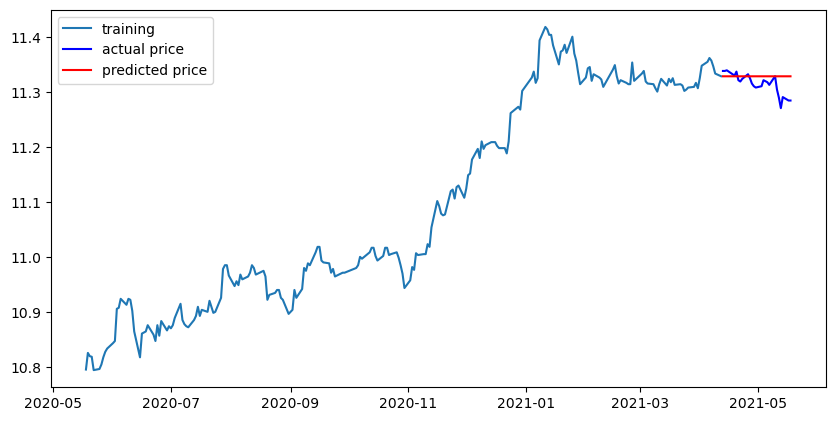

In [39]:
fc = result_test(fitted_m, train_data, test_data)

- test에 해당하는 실제 가격은 떨어지는 추세를 보임
- 학습은 통한 예측 가격은 유지하는 것으로 나타냄
- ARIMA 모수 중 p를 1로 지정하여 시차가 적어 일직선처럼 보이는 것으로 판단됨

## loss 계산

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def cal_loss(test_data, fc):
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

In [41]:
cal_loss(test_data, fc)

MSE:  3480513.727391048
MAE:  1403.0337201164832
RMSE:  1865.6134989303246
MAPE: 1.74%


- **MAPE가 1.74%로 평가됨**

## ARIMA 모델 훈련2 - order=(13, 1, 0)

In [42]:
# Build and Train  Model
model2 = ARIMA(train_data, order=(13, 1, 0))  # (p, d, q)
fitted_m2 = model2.fit() 

print(fitted_m2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(13, 1, 0)   Log Likelihood                 587.274
Date:                Fri, 11 Feb 2022   AIC                          -1146.548
Time:                        15:34:02   BIC                          -1098.785
Sample:                             0   HQIC                         -1127.268
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0428      0.066      0.643      0.520      -0.087       0.173
ar.L2         -0.0146      0.080     -0.184      0.854      -0.171       0.142
ar.L3         -0.0395      0.075     -0.527      0.5

## 훈련 결과

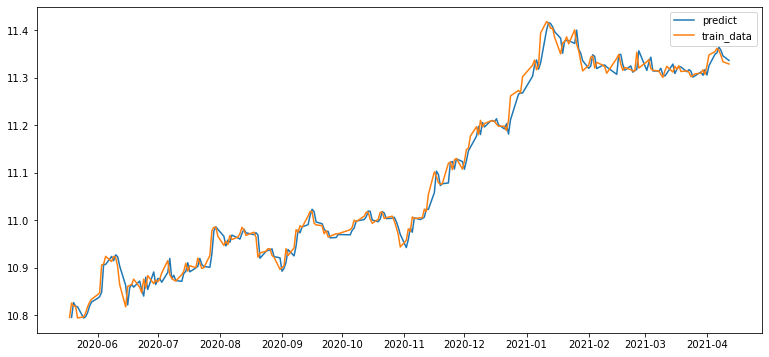

In [43]:
result_pred(fitted_m2, train_data)

- 학습을 통해 얻은 예측값(Pred2)과 실제 train_data의 주식 가격 변동 흐름은 비슷하게 나타남

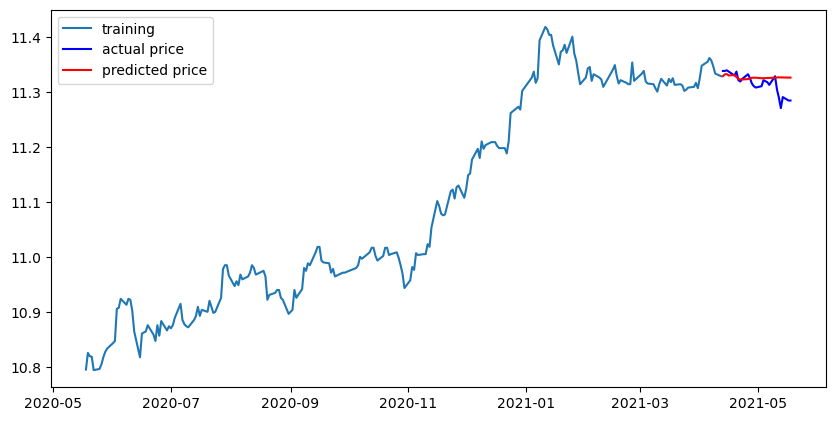

In [44]:
fc2 = result_test(fitted_m2, train_data, test_data)

- test에 해당하는 실제 가격은 떨어지는 추세를 보임
- 학습은 통한 예측 가격은 유지하는 것으로 나타냄
- ARIMA 모수 중 p를 13로 지정하여 초반 시차는 곡선을 그리지만 나중에는 일직선처럼 보이는 것으로 판단됨

## loss 계산

In [45]:
cal_loss(test_data, fc2)

MSE:  2993797.7932514017
MAE:  1230.9720930400329
RMSE:  1730.2594583620694
MAPE: 1.52%


- **MAPE가 1.52%로 평가됨**

## ARIMA 모델 훈련3 - order=(21, 1, 0)

In [46]:
# Build and Train  Model
model3 = ARIMA(train_data, order=(21, 1, 0))  # (p, d, q)
fitted_m3 = model3.fit() 

print(fitted_m3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(21, 1, 0)   Log Likelihood                 589.437
Date:                Fri, 11 Feb 2022   AIC                          -1134.875
Time:                        15:34:04   BIC                          -1059.819
Sample:                             0   HQIC                         -1104.578
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0382      0.070      0.543      0.587      -0.100       0.176
ar.L2         -0.0200      0.082     -0.243      0.808      -0.181       0.141
ar.L3         -0.0419      0.083     -0.507      0.6

## 훈련 결과

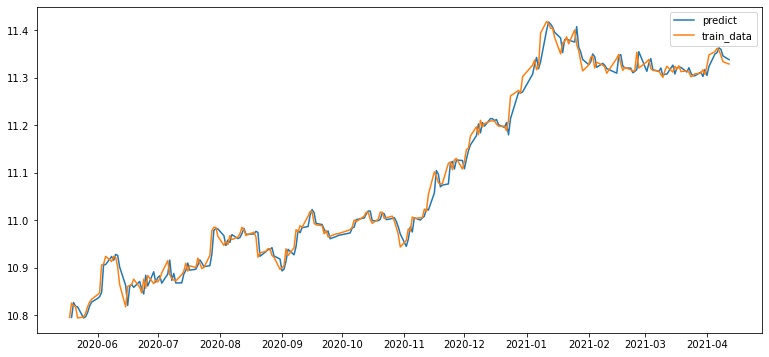

In [47]:
result_pred(fitted_m3, train_data)

- 학습을 통해 얻은 예측값(Pred3)과 실제 train_data의 주식 가격 변동 흐름은 비슷하게 나타남

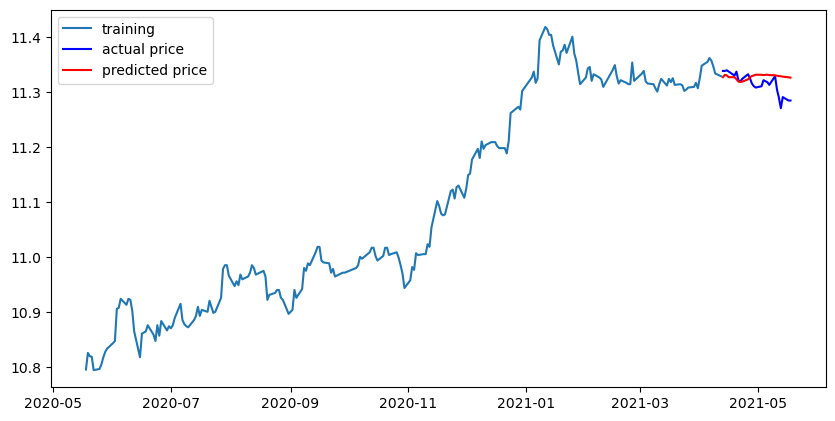

In [48]:
fc3 = result_test(fitted_m3, train_data, test_data)

- test에 해당하는 실제 가격은 떨어지는 추세를 보임
- 학습은 통한 예측 가격은 유지하는 것으로 나타냄
- ARIMA 모수 중 p를 21로 지정하여 기존보다 좀 더 곡선을 띔

## loss 계산

In [49]:
cal_loss(test_data, fc3)

MSE:  3543194.66464531
MAE:  1436.7626841040492
RMSE:  1882.3375533217495
MAPE: 1.78%


- **MAPE가 1.78%로 평가됨**

## 다른 종목으로 주식 가격 예측하기 - SK 하이닉스 (SK hynix Inc. (000660.KS))

In [50]:
df_sk = load_data('000660.KS.csv')

In [51]:
df_sk.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-10,125500.0,127000.0,124500.0,126000.0,124478.117188,4262526
2021-02-15,130000.0,132500.0,130000.0,132000.0,130405.648438,5384526
2021-02-16,132500.0,134000.0,130500.0,132500.0,130899.609375,3218689
2021-02-17,131000.0,131000.0,128000.0,130000.0,128429.804688,3621178
2021-02-18,128500.0,130000.0,125500.0,126000.0,124478.117188,3792425


In [52]:
ts_sk = df_sk['Close']

ts_sk.head(15)

Date
2021-02-10    126000.0
2021-02-15    132000.0
2021-02-16    132500.0
2021-02-17    130000.0
2021-02-18    126000.0
2021-02-19    133000.0
2021-02-22    136500.0
2021-02-23    138500.0
2021-02-24    136000.0
2021-02-25    148500.0
2021-02-26    141500.0
2021-03-02    144500.0
2021-03-03    147000.0
2021-03-04    142000.0
2021-03-05    140000.0
Name: Close, dtype: float64

In [53]:
len(ts_sk)

246

- 246일 동안의 주식가격을 가지고 있는 데이터가 있음

## Preprocessing

### 1. 결측치 확인

In [54]:
ts_sk.isnull().sum()

0

- 결측치는 존재하지 않음

### 2. 인덱스(날짜) 중복 여부 판단

In [55]:
len(ts_sk.index.unique())

246

- unique()를 통해 고유한 index를 나타냄
- len()을 통해 고유한 index의 갯수를 파악
- data 갯수와 고유한 index의 갯수가 일치함
- index의 중복을 없을 것으로 판단됨

## 3. log 변환

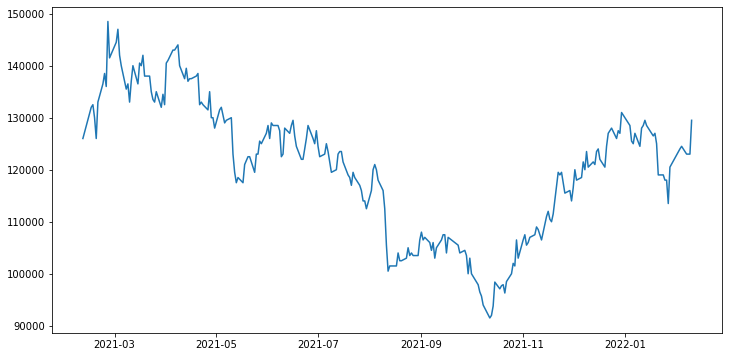

In [56]:
rcParams['figure.figsize'] = 12, 6
plt.plot(ts_sk)

- 시간 추이에 따라 분산이 점점 커짐
- log변환이 필요함

In [57]:
ts_sk_log = np.log(ts_sk)

- ts_sk를 log 변환시킴

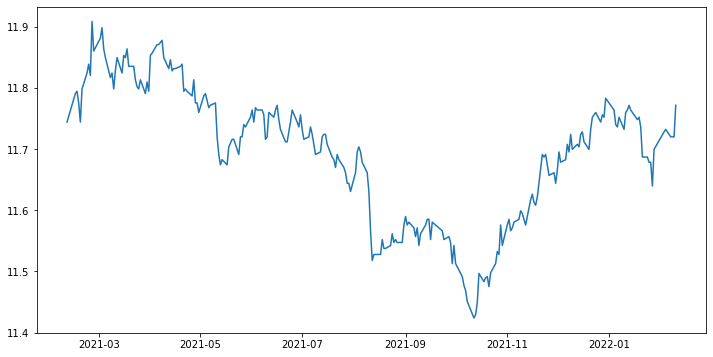

In [58]:
rcParams['figure.figsize'] = 12, 6
plt.plot(ts_sk_log)

- log 변환을 통해 작은 값은 비교적 커지고 큰 값은 비교적 작아짐

## 시계열 안정성 분석

- 시계열적으로 안정적이지 않은 주식 그래프를 분석하고 안정적인 형태로 변환하는 과정이 필요함

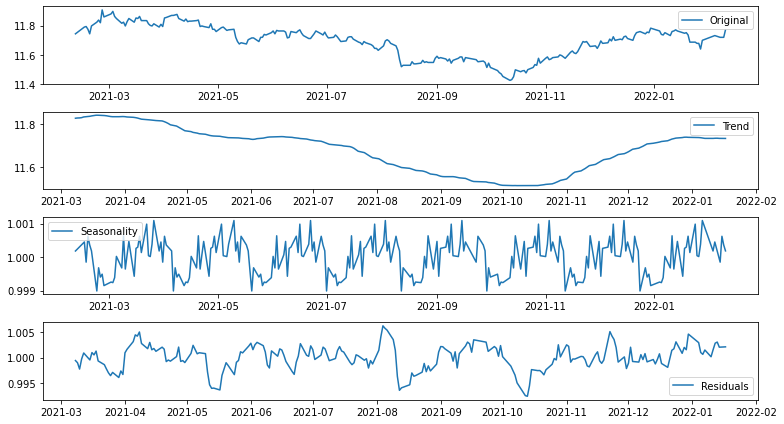

In [59]:
seperater_pattern_detail(ts_sk_log)

- Original = Trend + Seasonality + Residual
- Residual = Original - Trend - Seasonality

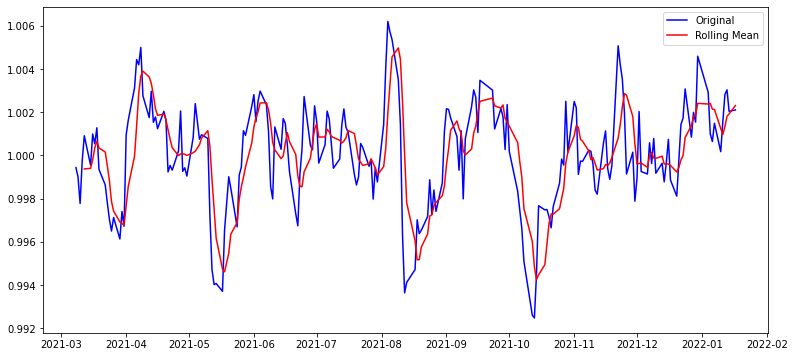

Results of Dickey-Fuller Test:
Test Statistic                  -5.511192
p-value                          0.000002
#Lags Used                       2.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


In [60]:
residual_detail(ts_sk_log)

- p-value가 0에 가까워 시계열 데이터가 안정적이라고 할 수 있음
- 이번 데이터를 ARIMA 모델로 학습 가능

## Train, Test셋 분리

In [61]:
train_data_sk, test_data_sk = ts_sk_log[:int(len(ts_sk_log)*0.9)], ts_sk_log[int(len(ts_sk_log)*0.9):]

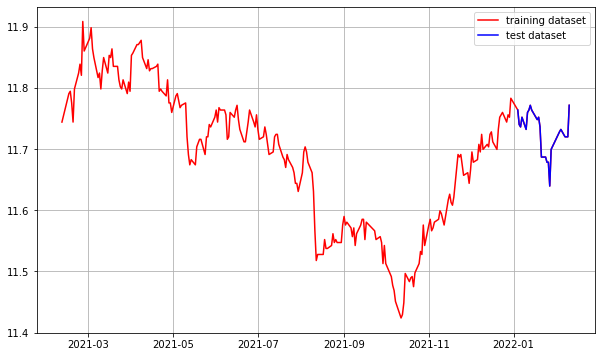

In [62]:
plot_train_test(ts_sk_log, test_data_sk)

In [63]:
print(train_data_sk.shape)
print(test_data_sk.shape)

(221,)
(25,)


## ARIMA 모델의 모수 찾기 (p, d, q)

### 1. p, q 구하기

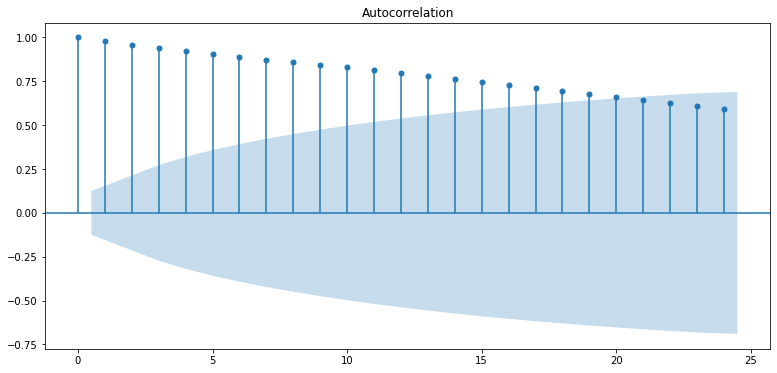

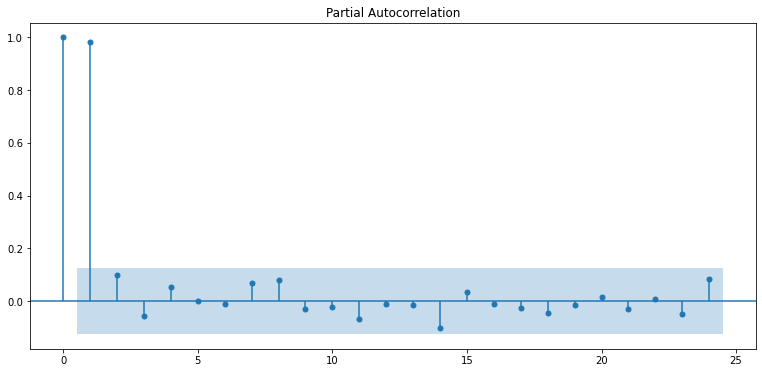

In [64]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_sk_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_sk_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- Lag 0은 자기자신과의 관련성이므로 ACF와 PACF 모두 1임
- ACF는 시차 간격이 벌어지면서 관련성이 점차 떨어질 수 있으므로 점차적으로 감소함
- PACF가 1번 이후에 0에 가까워짐
- AR(1)에 적합함

### 2. d를 구하기
- d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 보아야 함

#### 2-1. 1차 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.689661e+01
p-value                        1.035319e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


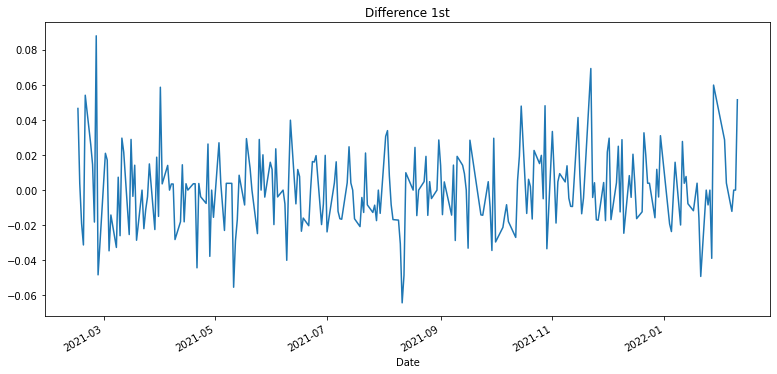

In [65]:
# 1차 차분 구하기
diff_1 = ts_sk_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#### 4-2. 2차 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -8.139857e+00
p-value                        1.035170e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


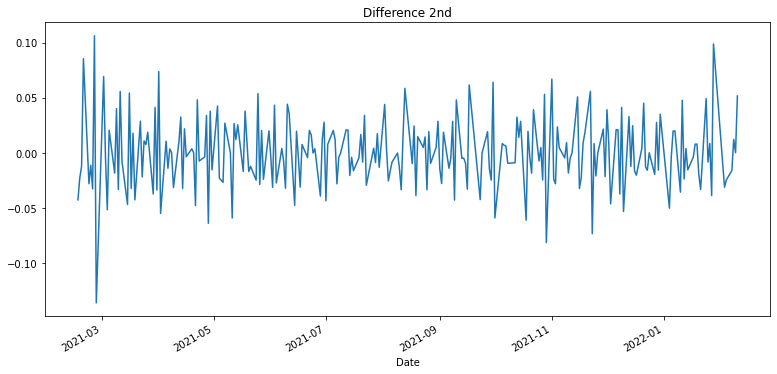

In [66]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 1차 차분의 p-value값이 2차 차분의 p-value값보다 낮아 1차 차분을 활용
- d = 1로 지정

### 모수 p, d, q는 (1, 1, 0)으로 지정함

## ARIMA 모델 훈련

In [67]:
# Build and Train  Model
model_sk = ARIMA(train_data_sk, order=(1, 1, 0))  # (p, d, q)
fitted_m_sk = model_sk.fit() 

print(fitted_m_sk.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 529.288
Date:                Fri, 11 Feb 2022   AIC                          -1054.576
Time:                        15:34:07   BIC                          -1047.789
Sample:                             0   HQIC                         -1051.835
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0888      0.059     -1.512      0.130      -0.204       0.026
sigma2         0.0005   3.65e-05     13.039      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-

## 훈련 결과

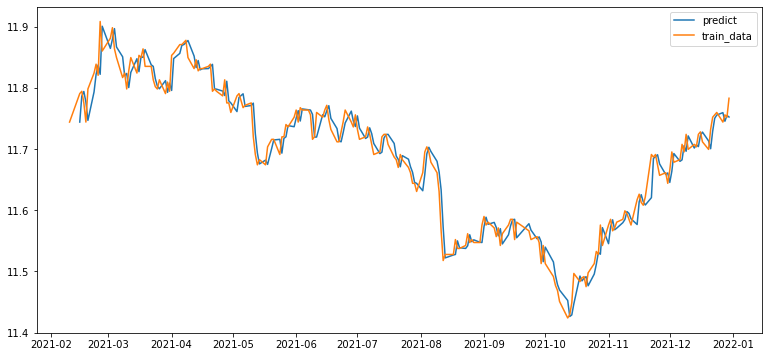

In [68]:
result_pred(fitted_m_sk, train_data_sk)

- 학습을 통해 얻은 예측값(Pred)과 실제 train_data의 주식 가격 변동 흐름은 비슷하게 나타남

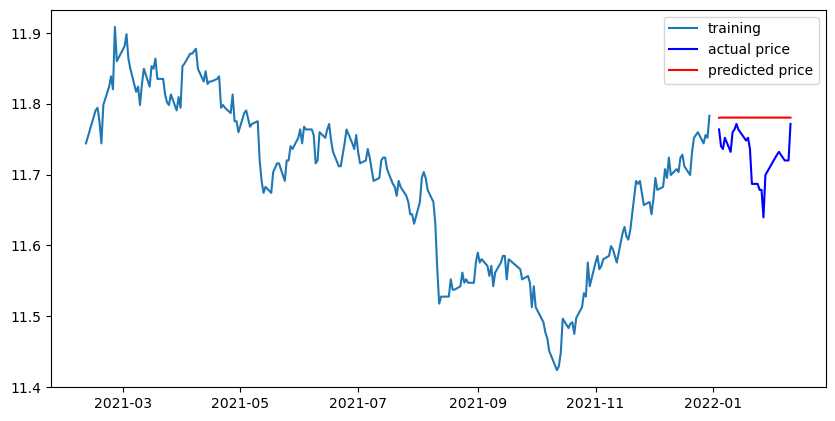

In [69]:
fc_sk = result_test(fitted_m_sk, train_data_sk, test_data_sk)

- test에 해당하는 실제 가격은 떨어지졌다가 오르는 추세를 보임
- 학습은 통한 예측 가격은 유지하는 것으로 나타냄
- ARIMA 모수 중 p를 1로 지정하여 시차가 적어 일직선처럼 보이는 것으로 판단됨

## loss 계산

In [70]:
cal_loss(test_data_sk, fc_sk)

MSE:  58449598.05883565
MAE:  6448.114438692348
RMSE:  7645.233682421725
MAPE: 5.31%


- **MAPE가 5.31%로 평가됨**

## 다른 종목으로 주식 가격 예측하기 - 현대자동차 (Hyundai Motor Company (005380.KS))

In [71]:
df_hd = load_data('005380.KS.csv')

In [72]:
df_hd.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-11,126000.0,129000.0,126000.0,127500.0,118776.687500,425879
2019-02-12,129000.0,129000.0,126500.0,128500.0,119708.265625,443035
2019-02-13,128500.0,128500.0,124000.0,124500.0,115981.945313,620173
2019-02-14,123500.0,124000.0,119500.0,121500.0,113187.195313,1072937
2019-02-15,121000.0,121500.0,120000.0,121000.0,112721.406250,446734


In [73]:
ts_hd = df_hd['Close']

ts_hd.head(15)

Date
2019-02-11    127500.0
2019-02-12    128500.0
2019-02-13    124500.0
2019-02-14    121500.0
2019-02-15    121000.0
2019-02-18    120500.0
2019-02-19    119500.0
2019-02-20    119000.0
2019-02-21    120000.0
2019-02-22    121000.0
2019-02-25    121000.0
2019-02-26    122500.0
2019-02-27    129000.0
2019-02-28    126500.0
2019-03-04    122000.0
Name: Close, dtype: float64

In [74]:
len(ts_hd)

742

- 742일(3년) 동안의 주식가격을 가지고 있는 데이터가 있음 (주말 제외)

## Preprocessing

### 1. 결측치 확인

In [75]:
ts_hd.isnull().sum()

0

- 결측치는 존재하지 않음

### 2. 인덱스(날짜) 중복 여부 판단

In [76]:
len(ts_hd.index.unique())

742

- unique()를 통해 고유한 index를 나타냄
- len()을 통해 고유한 index의 갯수를 파악
- data 갯수와 고유한 index의 갯수가 일치함
- index의 중복을 없을 것으로 판단됨

## 3. log 변환

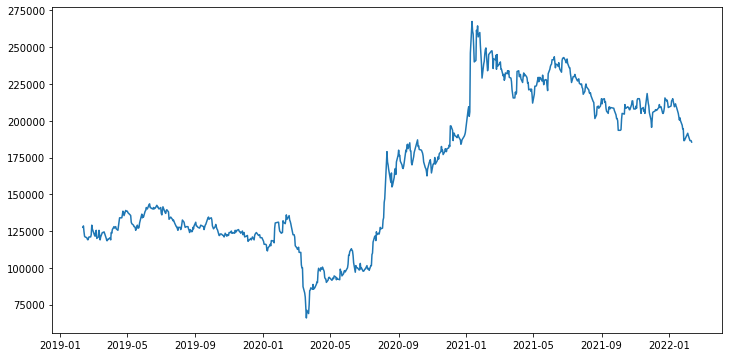

In [77]:
rcParams['figure.figsize'] = 12, 6
plt.plot(ts_hd)

- 시간 추이에 따라 분산이 점점 커짐
- log변환이 필요함

In [78]:
ts_hd_log = np.log(ts_hd)

- ts_hd를 log 변환시킴

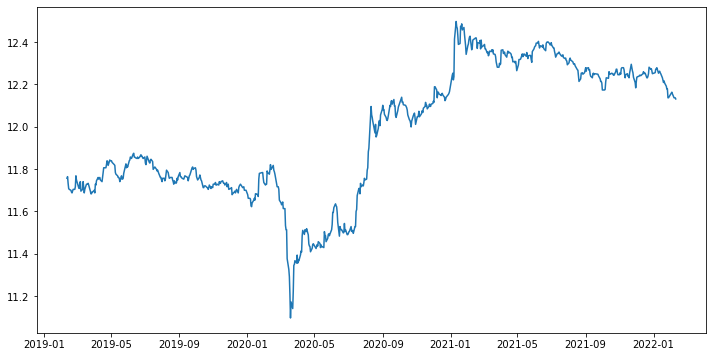

In [79]:
rcParams['figure.figsize'] = 12, 6
plt.plot(ts_hd_log)

- log 변환을 통해 작은 값은 비교적 커지고 큰 값은 비교적 작아짐

## 시계열 안정성 분석

- 시계열적으로 안정적이지 않은 주식 그래프를 분석하고 안정적인 형태로 변환하는 과정이 필요함

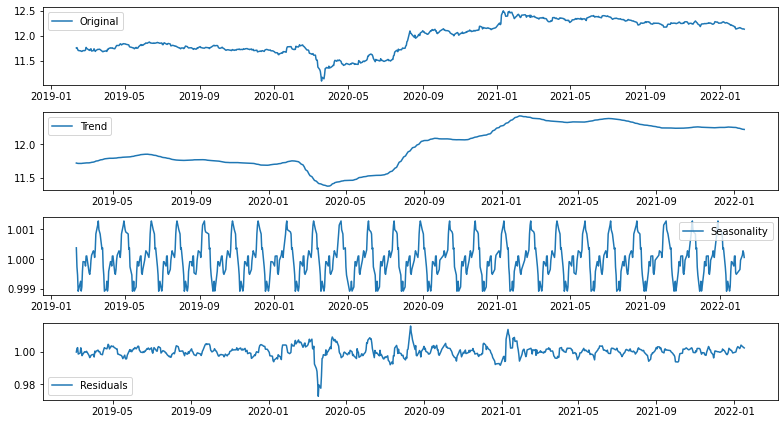

In [80]:
seperater_pattern_detail(ts_hd_log)

- Original = Trend + Seasonality + Residual
- Residual = Original - Trend - Seasonality

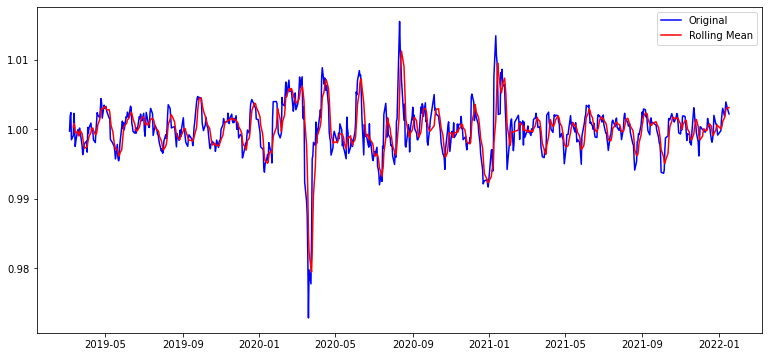

Results of Dickey-Fuller Test:
Test Statistic                -8.555208e+00
p-value                        8.998037e-14
#Lags Used                     1.600000e+01
Number of Observations Used    6.950000e+02
Critical Value (1%)           -3.439794e+00
Critical Value (5%)           -2.865708e+00
Critical Value (10%)          -2.568989e+00
dtype: float64


In [81]:
residual_detail(ts_hd_log)

- p-value가 0에 가까워 시계열 데이터가 안정적이라고 할 수 있음
- 이번 데이터를 ARIMA 모델로 학습 가능

## Train, Test셋 분리

In [82]:
train_data_hd, test_data_hd = ts_hd_log[:int(len(ts_hd_log)*0.9)], ts_hd_log[int(len(ts_hd_log)*0.9):]

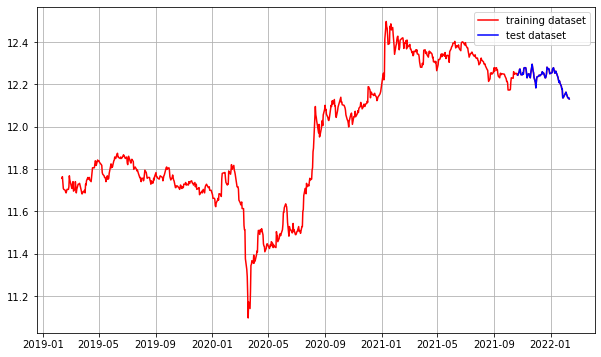

In [83]:
plot_train_test(ts_hd_log, test_data_hd)

- ts_log의 0번부터 90퍼센트 전까지는 train_data로 지정
- ts_log의 90퍼센트 지점부터 마지막 데이터까지는 test_data로 지정

In [84]:
print(train_data_hd.shape)
print(test_data_hd.shape)

(667,)
(75,)


## ARIMA 모델의 모수 찾기 (p, d, q)

### 1. p, q 구하기

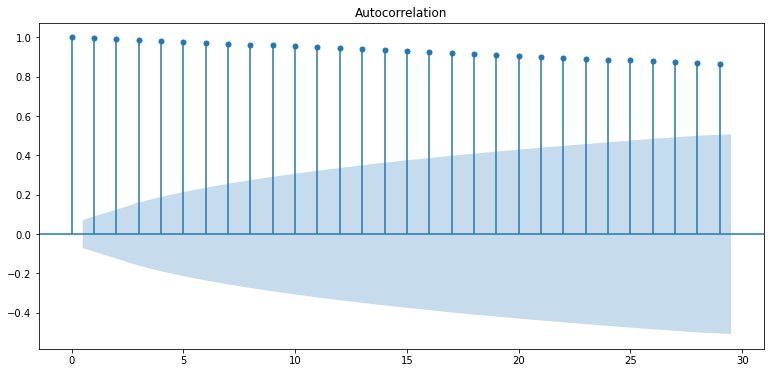

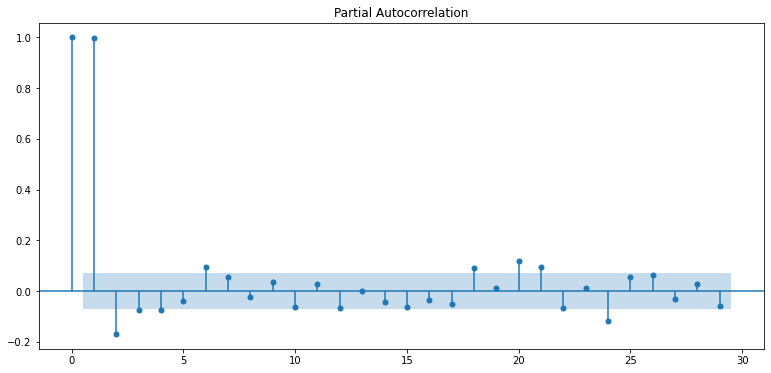

In [85]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_acf(ts_hd_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_hd_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- Lag 0은 자기자신과의 관련성이므로 ACF와 PACF 모두 1임
- ACF는 시차 간격이 벌어지면서 관련성이 점차 떨어질 수 있으므로 점차적으로 감소함
- PACF가 1번 이후에 0에 가까워짐
- AR(1)에 적합함
- AR(24)도 고려해볼 예정

### 2. d를 구하기
- d차 차분을 구해 보고 이때 시계열이 안정된 상태인지를 확인해 보아야 함

#### 2-1. 1차 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.734529e+01
p-value                        5.310399e-30
#Lags Used                     1.000000e+00
Number of Observations Used    7.390000e+02
Critical Value (1%)           -3.439230e+00
Critical Value (5%)           -2.865459e+00
Critical Value (10%)          -2.568857e+00
dtype: float64


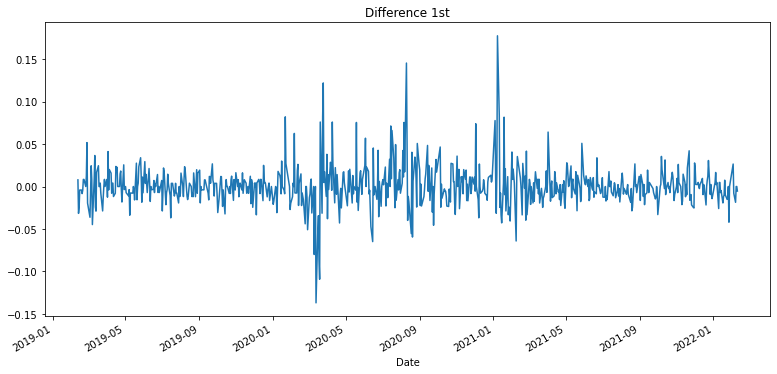

In [86]:
# 1차 차분 구하기
diff_1 = ts_hd_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

#### 4-2. 2차 차분 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.283219e+01
p-value                        5.841486e-24
#Lags Used                     1.400000e+01
Number of Observations Used    7.250000e+02
Critical Value (1%)           -3.439402e+00
Critical Value (5%)           -2.865535e+00
Critical Value (10%)          -2.568897e+00
dtype: float64


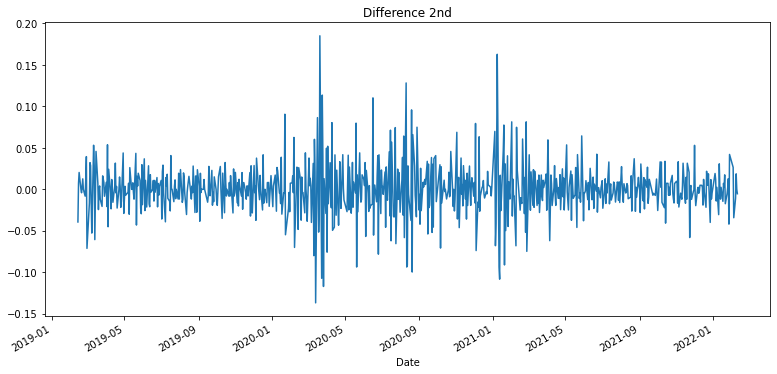

In [87]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 1차 차분의 p-value값이 2차 차분의 p-value값보다 낮아 1차 차분을 활용
- d = 1로 지정

### 모수 p, d, q는 (1, 1, 0)으로 지정함

## ARIMA 모델 훈련

In [88]:
# Build and Train  Model
model_hd = ARIMA(train_data_hd, order=(1, 1, 0))  # (p, d, q)
fitted_m_hd = model_hd.fit() 

print(fitted_m_hd.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  667
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1530.852
Date:                Fri, 11 Feb 2022   AIC                          -3057.703
Time:                        15:34:10   BIC                          -3048.701
Sample:                             0   HQIC                         -3054.215
                                - 667                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1168      0.025      4.740      0.000       0.069       0.165
sigma2         0.0006   1.41e-05     41.922      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.03   Jarque-

## 훈련 결과

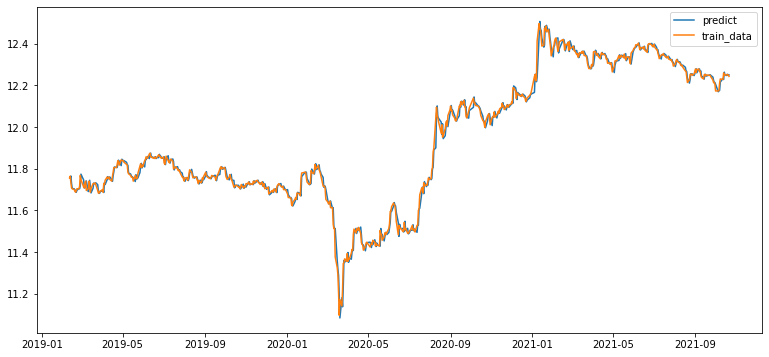

In [89]:
result_pred(fitted_m_hd, train_data_hd)

- 학습을 통해 얻은 예측값(Pred)과 실제 train_data의 주식 가격 변동 흐름은 비슷하게 나타남

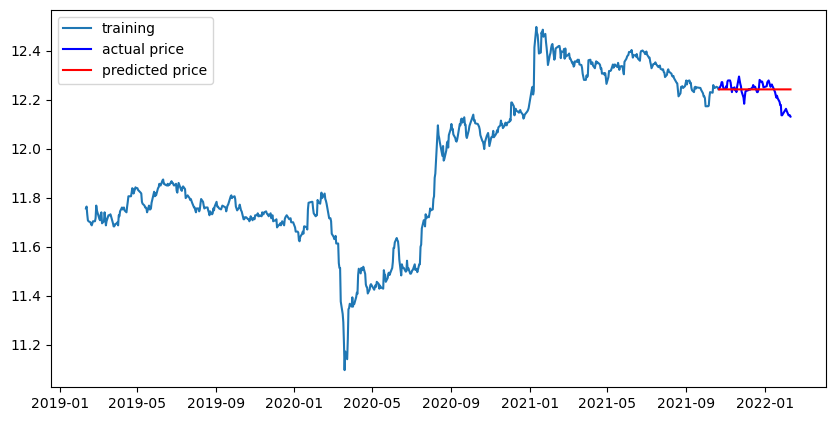

In [90]:
fc_hd = result_test(fitted_m_hd, train_data_hd, test_data_hd)

- test에 해당하는 실제 가격은 떨어지는 추세를 보임
- 학습은 통한 예측 가격은 유지하는 것으로 나타냄
- ARIMA 모수 중 p를 1로 지정하여 시차가 적어 일직선처럼 보이는 것으로 판단됨

## loss 계산

In [91]:
cal_loss(test_data_hd, fc_hd)

MSE:  66159936.019769736
MAE:  5680.572973757106
RMSE:  8133.875830117505
MAPE: 2.85%


- **MAPE가 2.85%로 평가됨**

## 회고

### 1. 새로 알아갔던 점
 - 안정적이지 않은 시계열 데이터를 가공하여 안정적이게 만드는 것
 - 이동평균, ADF검정, 추세(trend), 계절성(seasonality), 주기성(cycle) 등에 대한 개념

### 2. 흥미로웠던 점
 - p-value를 보며 안정적이지 않은 시계열 데이터를 안정적이게 만들어가는 과정
 - ARIMA 모델이 어떻게 학습했는지 시각화하면서 본 점

### 3. 아쉬웠던 점
 - 익스의 설명이 너무 부족했다고 생각됨
 - ADF검정을 진행할 때, 단일근과 안정성이 어떻게 연관이 있는지 여러 자료를 찾아봤지만 제대로 이해하지 못함
 - 노드 내용 중에서 이번 노드 제작자분이 닌자코드를 사용함 (아래의 이미지)

### 4. 앞으로의 다짐
 - 시계열 데이터에 대한 지식을 좀 더 깊게 알아가야겠다는 다짐을 하게 됨

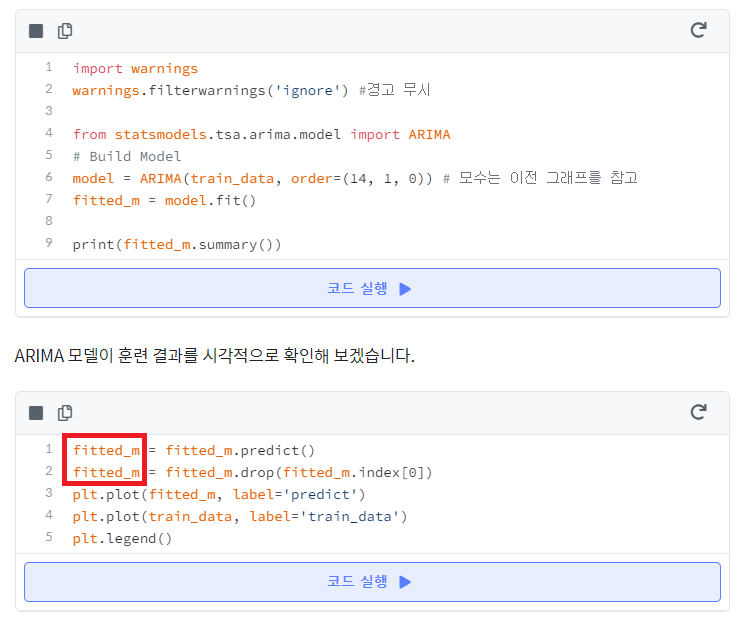